In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE: using 07 training runs, compare the empirical (unbiased) estimators of moments to original draws

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [3]:
path = "./learnt_models/07_args_shorter_training.dill" # 

with open(path, "rb") as f:
    args = dill.load(f)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


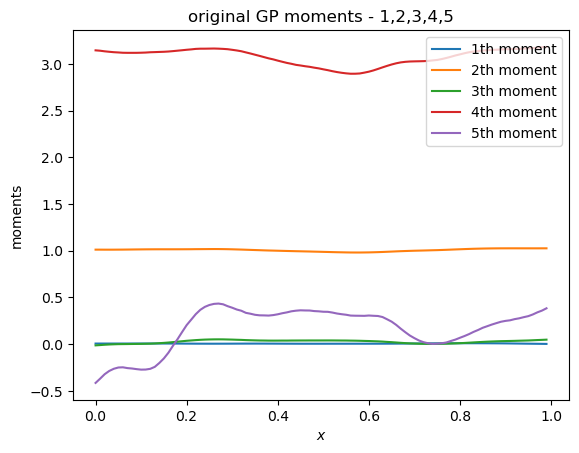

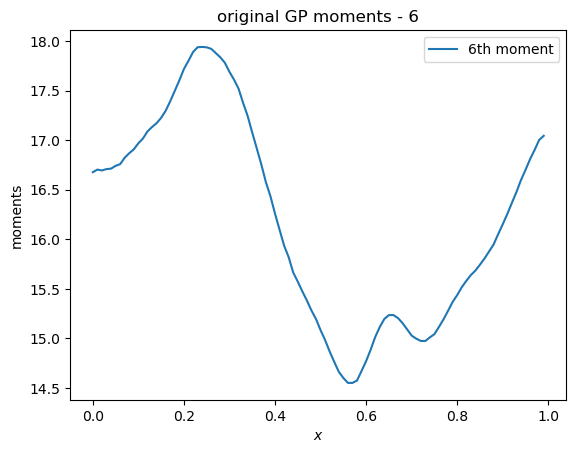

In [32]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

from reusable.moments import moment
from plotting.plots import plot_moments, plot_draws
rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

moments_compare = [1,2,3,4, 5]

gp_moments = [moment(i, gp_draws) for i in moments_compare]

plot_moments(gp_moments, moments_compare, args["x"], "original GP moments - " + ",".join([str(x) for x in moments_compare]))

sixth = [moment(6, gp_draws)]

plot_moments(sixth, [6], args["x"], "original GP moments - 6")


# Comparing training plots

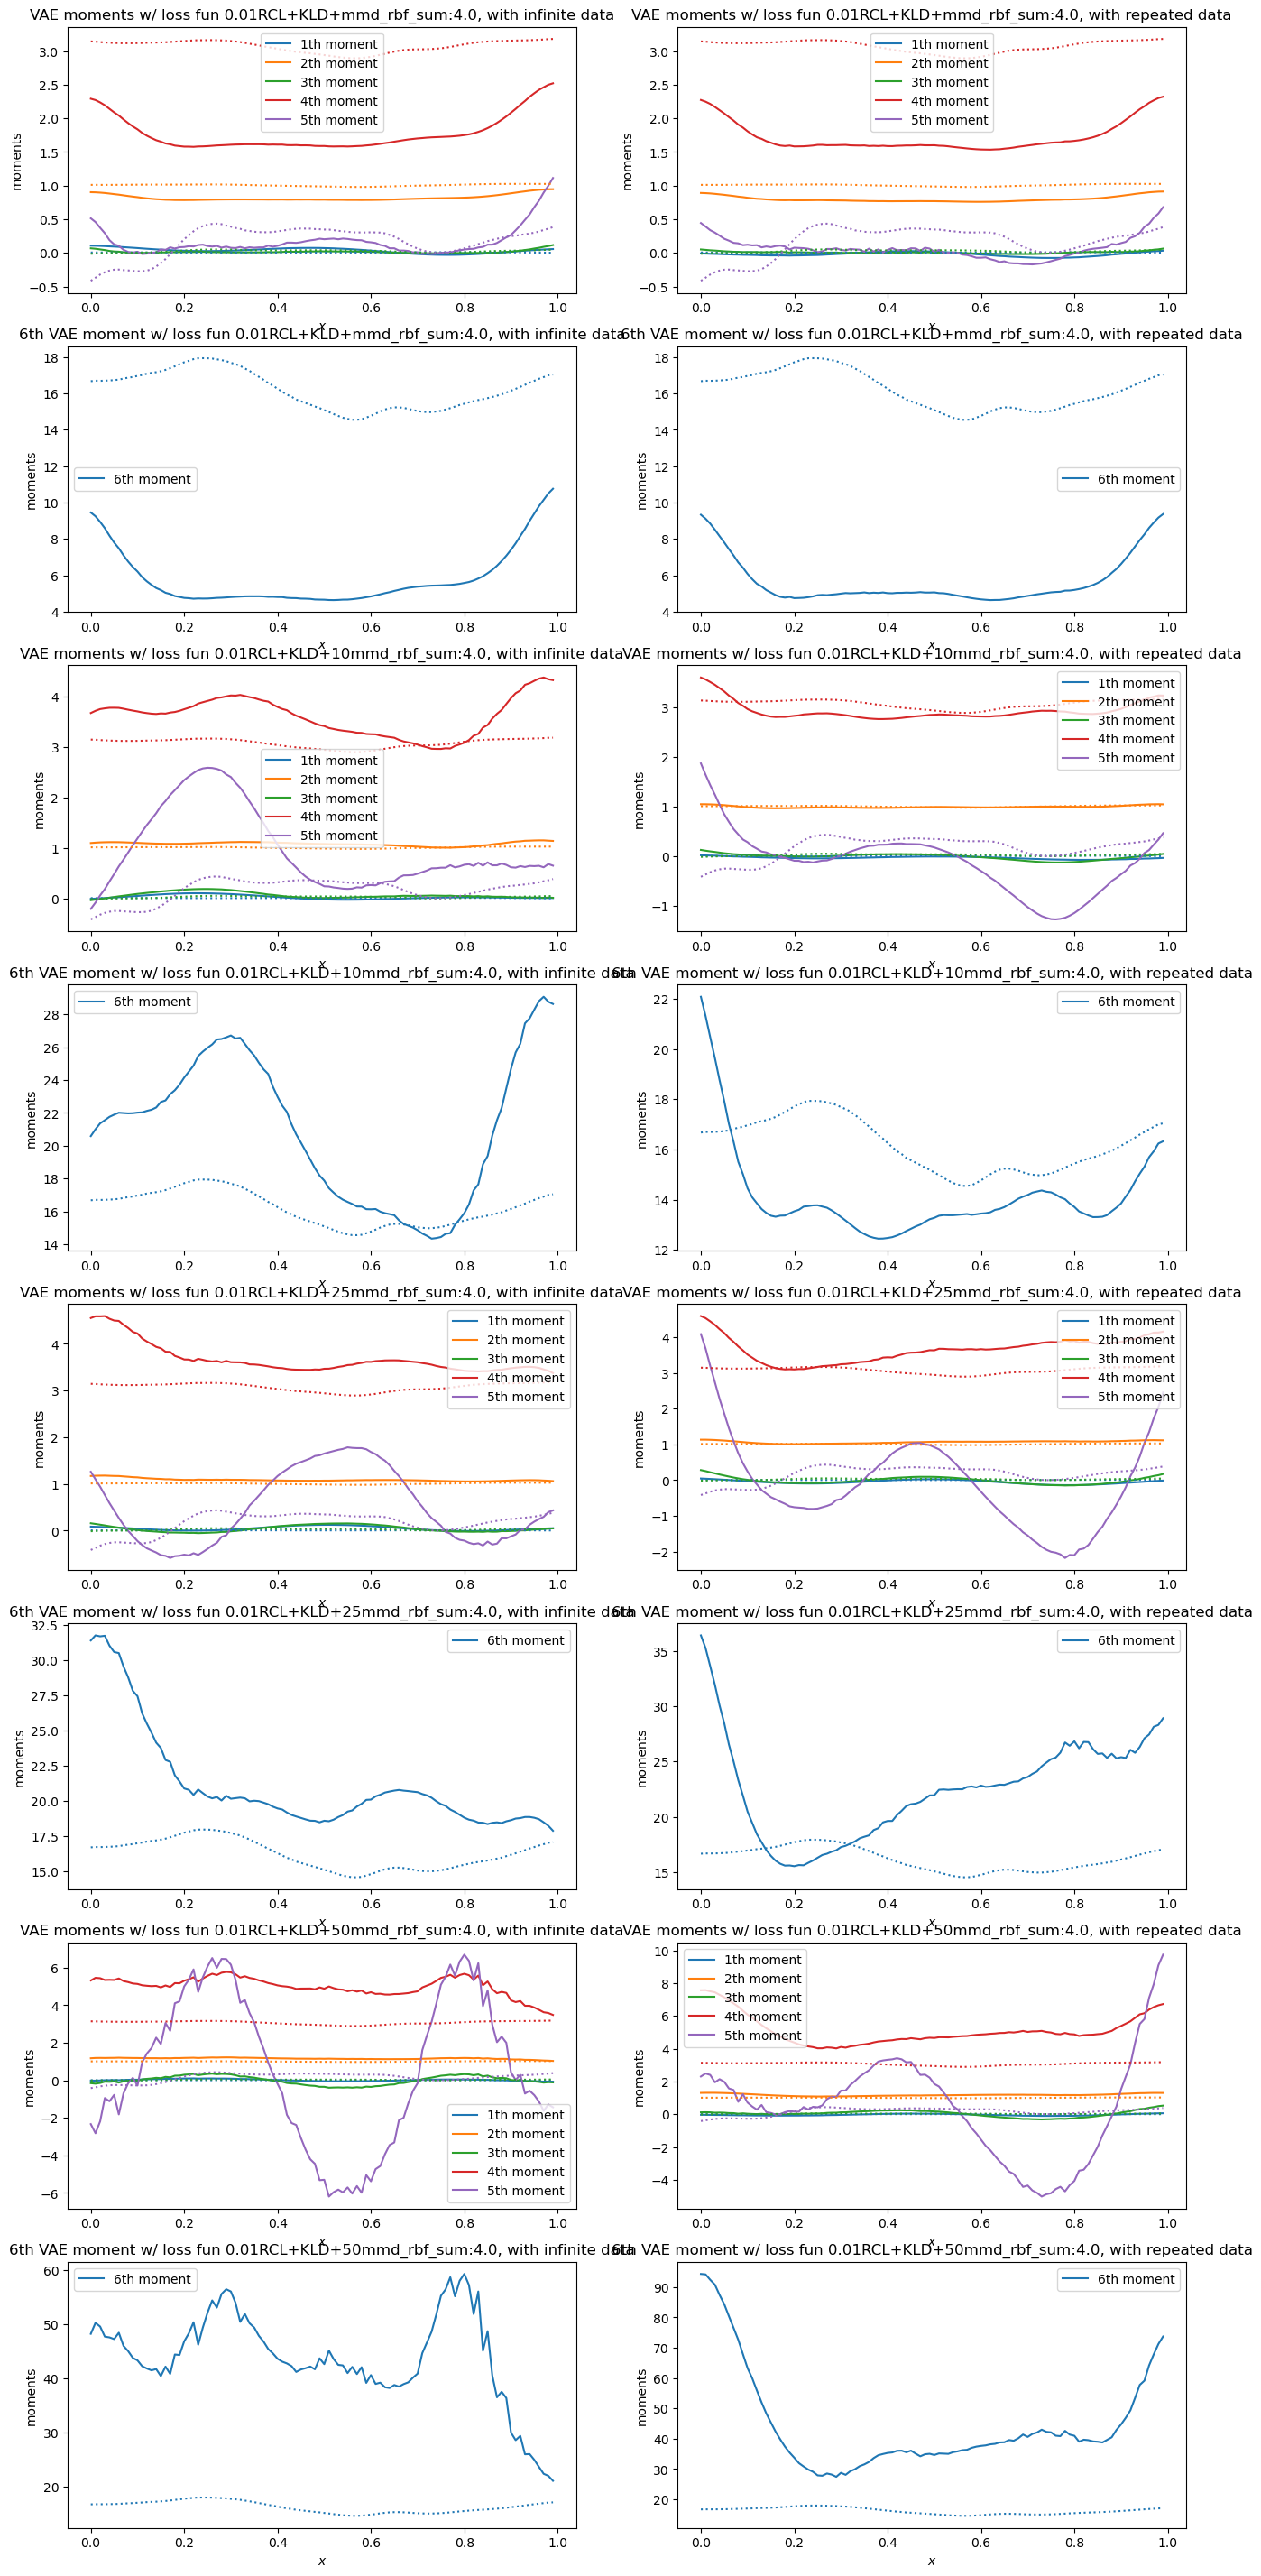

In [36]:
from plotting.plots import plot_moments, plot_draws_hpdi
moments_fig, moments_ax = plt.subplots(nrows=2 * len(args["loss_functions"]), ncols=2, figsize=(16, 36))

for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        path_inf = "_inf" if infinite else ""
        str_inf = "with infinite data" if infinite else "with repeated data"

        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=10000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            
            vae_moments = [moment(i, vae_draws) for i in moments_compare]

            plot_moments(vae_moments, moments_compare, args["x"], f"VAE moments w/ loss fun {loss_fn}, {str_inf}", ax=moments_ax[2 * i, j], correct_moments=gp_moments)

            plot_moments([moment(6, vae_draws)], [6], args["x"], f"6th VAE moment w/ loss fun {loss_fn}, {str_inf}", ax=moments_ax[2 * i +1, j], correct_moments=sixth)


            #plot_draws_hpdi(vae_draws, args["x"], f"VAE draws w/ loss fun {loss_fn}, {str_inf}", "$y=f_{VAE}(x)$", ax=draws_axs[i, j])
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

## Biased moments

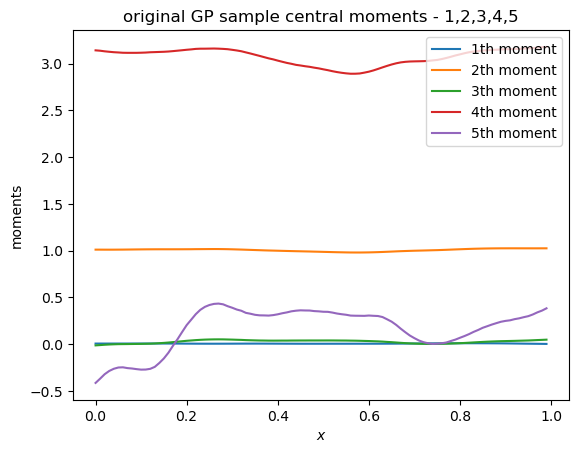

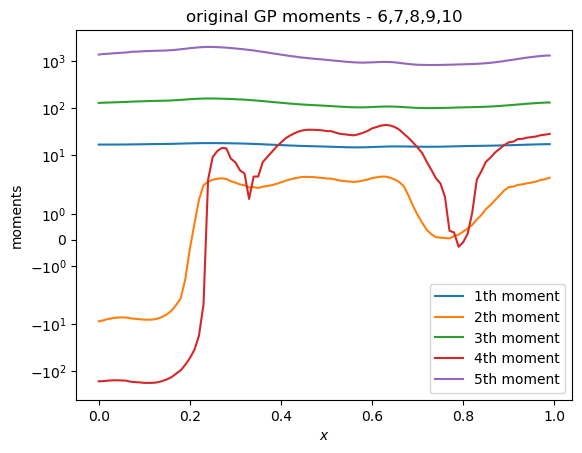

In [39]:
from reusable.moments import sample_central_moment
gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

moments_compareA = [1,2,3,4, 5]
moments_compareB = [6,7,8,9, 10]

gp_momentsA = [sample_central_moment(i, gp_draws) for i in moments_compareA]

plot_moments(gp_momentsA, moments_compare, args["x"], "original GP sample central moments - " + ",".join([str(x) for x in moments_compareA]))

gp_momentsB = [sample_central_moment(i, gp_draws) for i in moments_compareB]

plot_moments(gp_momentsB, moments_compare, args["x"], "original GP moments - " + ",".join([str(x) for x in moments_compareB]), scale="symlog")


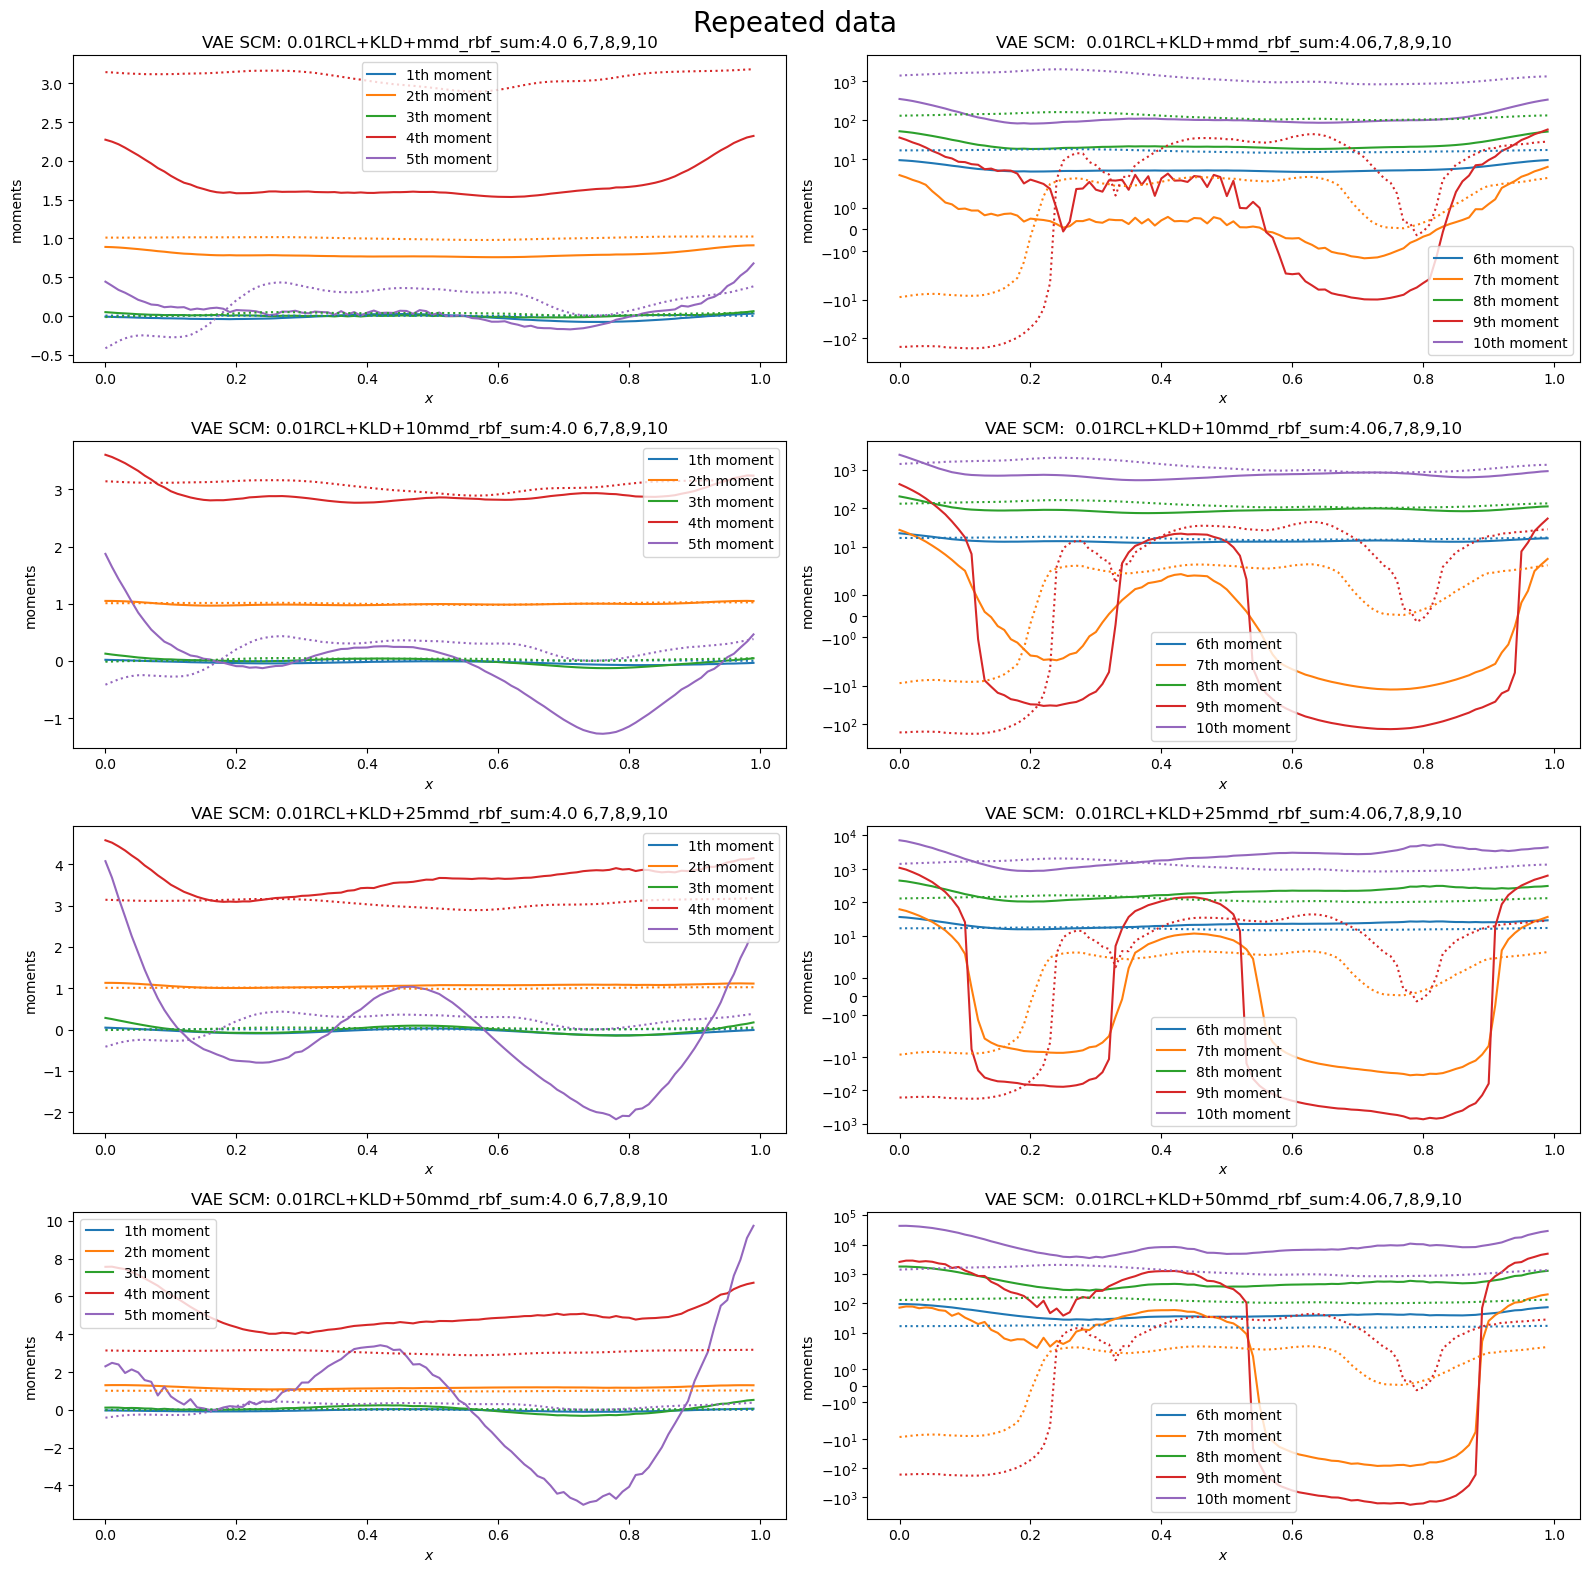

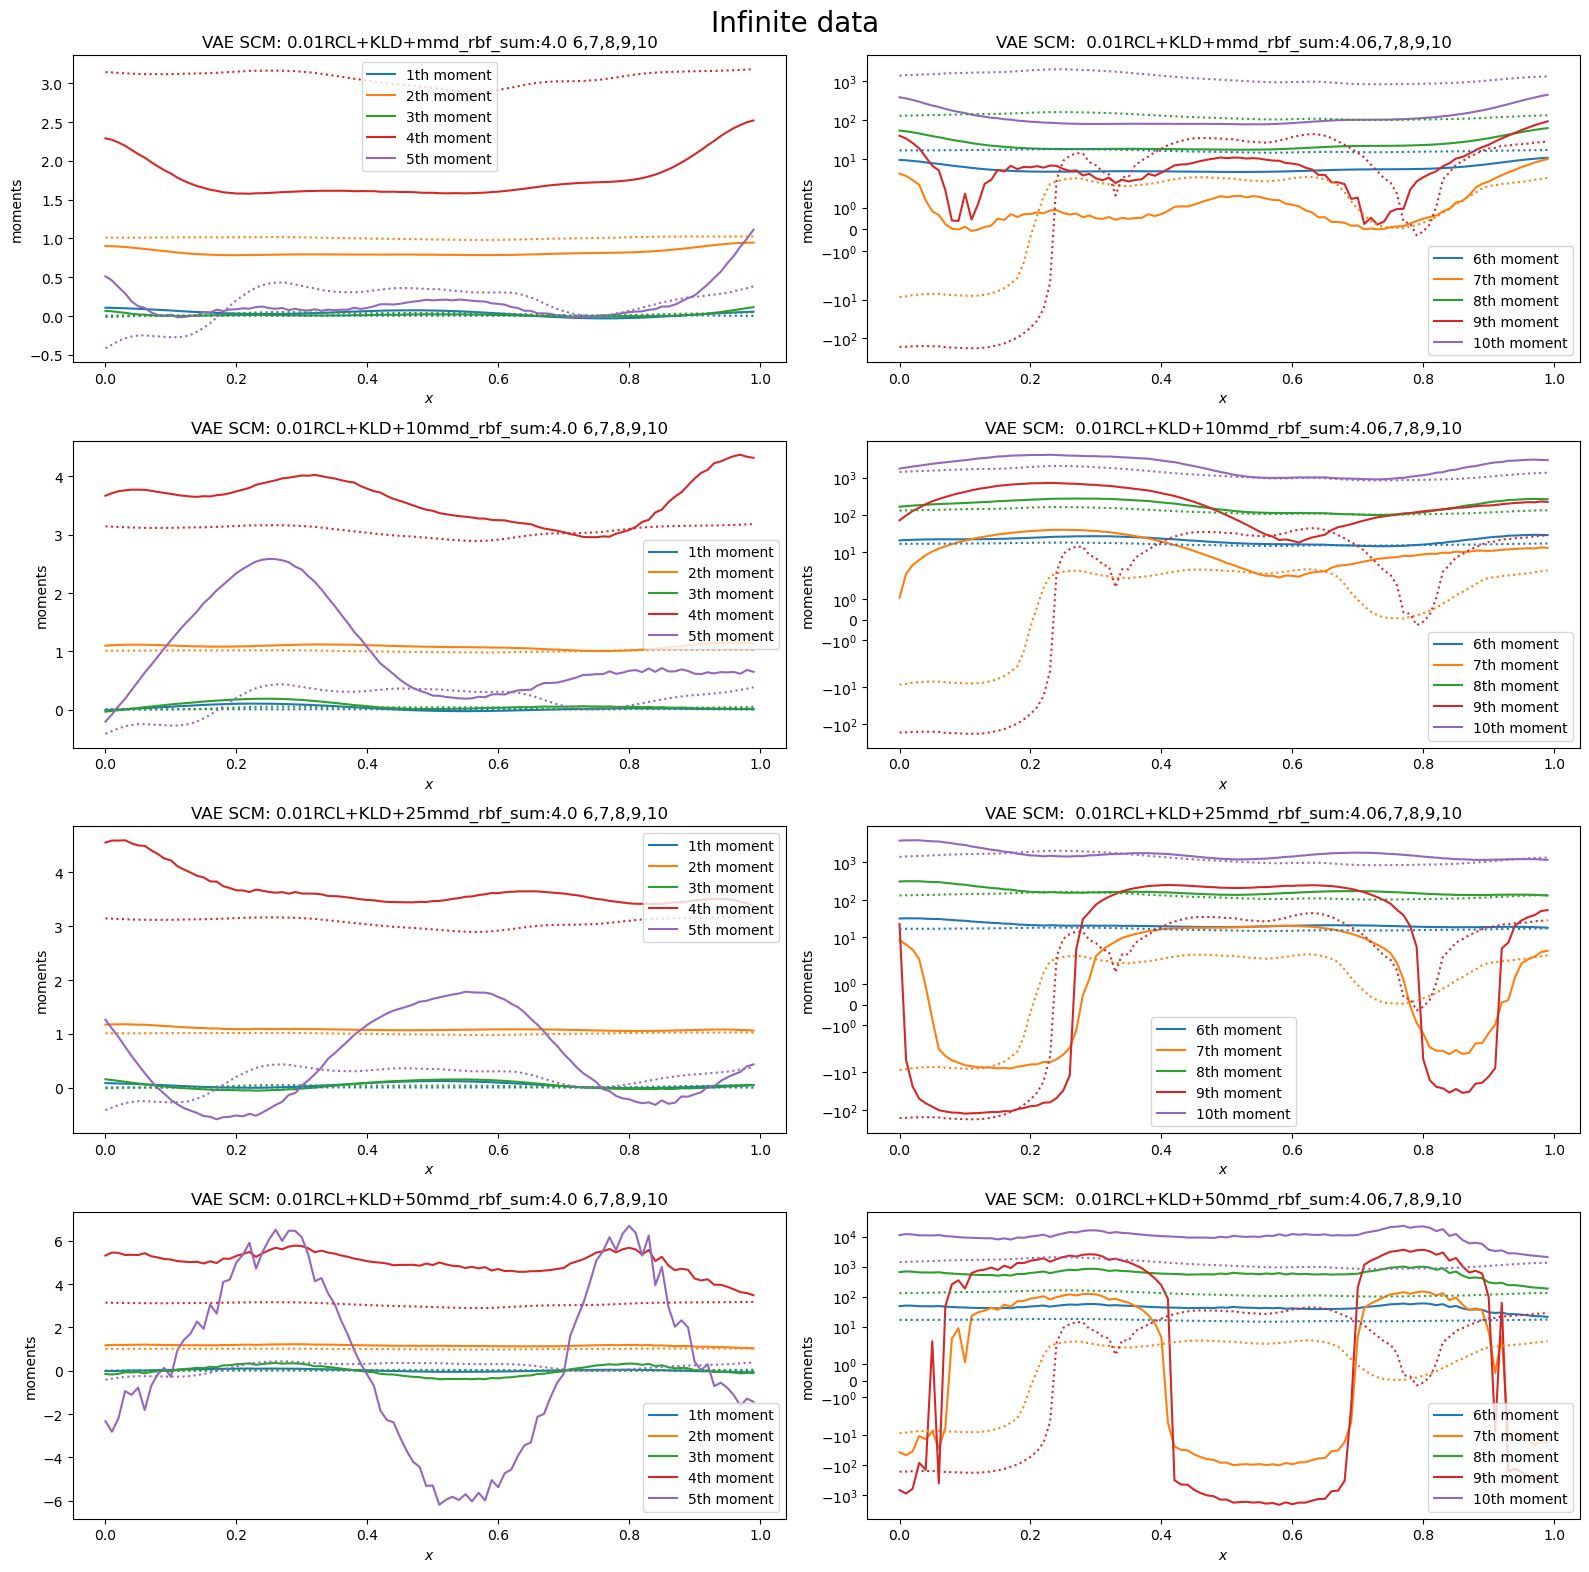

In [49]:
from plotting.plots import plot_moments, plot_draws_hpdi
moments_fig, moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
moments_fig.suptitle("Repeated data", fontsize=20)
inf_moments_fig, inf_moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
inf_moments_fig.suptitle("Infinite data", fontsize=20)

for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        path_inf = "_inf" if infinite else ""
        str_inf = "w/ inf data" if infinite else "w/ rep. data"
        ax = inf_moments_ax if infinite else moments_ax

        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=10000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            
            vae_momentsA = [sample_central_moment(i, vae_draws) for i in moments_compareA]
            vae_momentsB = [sample_central_moment(i, vae_draws) for i in moments_compareB]

            plot_moments(vae_momentsA, moments_compareA, args["x"], f"VAE SCM: {loss_fn} " + ",".join([str(x) for x in moments_compareB]), ax=ax[i, 0], correct_moments=gp_momentsA)

            plot_moments(vae_momentsB, moments_compareB, args["x"], f"VAE SCM:  {loss_fn}" + ",".join([str(x) for x in moments_compareB]), ax=ax[i, 1], correct_moments=gp_momentsB, scale="symlog")

        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

inf_moments_fig.tight_layout()
moments_fig.tight_layout()